## Import all the necesary libraries MNIST and download MNIST data

In [31]:
import numpy as np
import torch
import sys
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils import data
from torchvision import transforms
from torchvision.datasets import MNIST

import matplotlib.pyplot as plt
import time

from matplotlib.colors import LinearSegmentedColormap

from scipy import ndimage

cuda = torch.cuda.is_available()
cuda

False

5


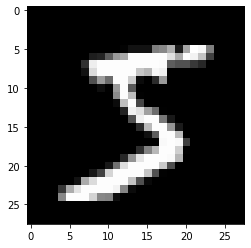

In [2]:
train = MNIST('./data', train=True, download=True, transform=transforms.ToTensor())

test = MNIST('./data', train=False, download=True, transform=transforms.ToTensor())
train_data = train.train_data
train_data = train.transform(train_data.numpy())

# Visualize a training instance with matplotlib
plt.imshow(train.train_data.cpu().numpy()[0], cmap='gray')
print (train.train_labels.cpu().numpy()[0])

In [3]:
# MODEL DEFINITION FOR LOADING
class My_CNN_Model(nn.Module):
    def __init__(self):
        super(My_CNN_Model, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5, padding = 0)
        self.pool1 = nn.MaxPool2d(2, stride = 2)
        self.conv2 = nn.Conv2d(6, 16, 5, padding = 0)
        self.pool2 = nn.MaxPool2d(2, stride = 2)#size is 4*4*16
        self.fc1 = nn.Linear(4*4*16, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x)) 
        x = self.pool2(x)
        x = x.view(-1, 4 * 4 * 16)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return x

# Start Comparison: Intgerated Gradients vs Saliency Maps

Reference : https://captum.ai/docs/extension/integrated_gradients

In [8]:
from captum.attr import Saliency, IntegratedGradients

In [9]:
#model = My_CNN_Model()
model = torch.load('MNIST_LeNet.pth')
model.eval()
#for param in model.parameters():
#    param.requires_grad = False

My_CNN_Model(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=256, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/captum/attr/_utils/gradient.py:33: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  "required_grads has been set automatically." % index


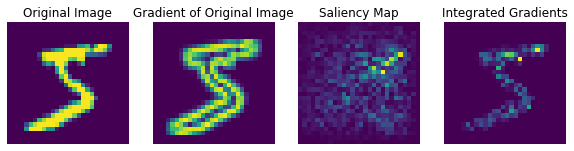

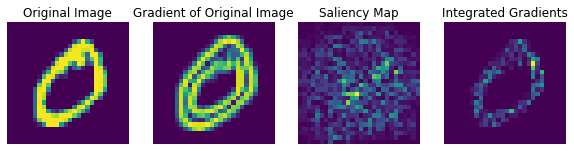

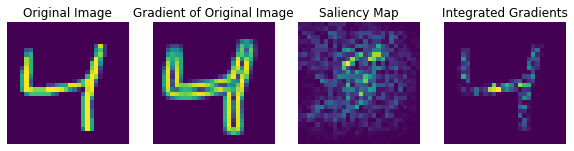

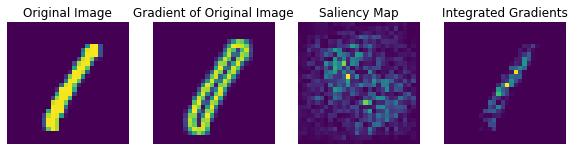

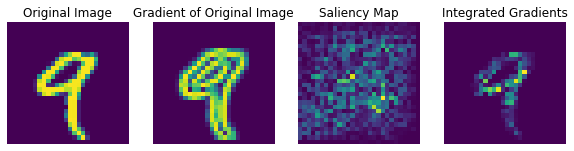

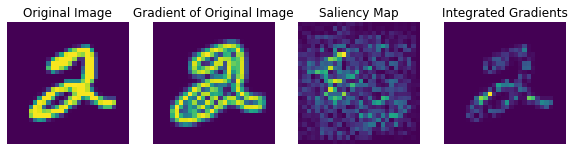

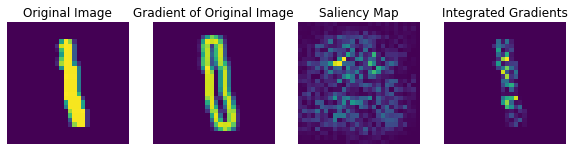

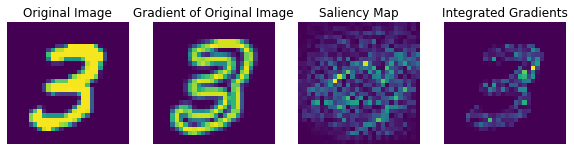

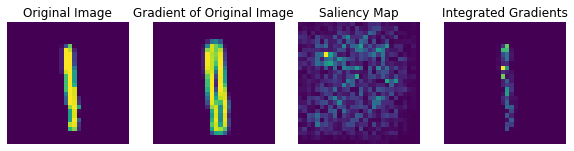

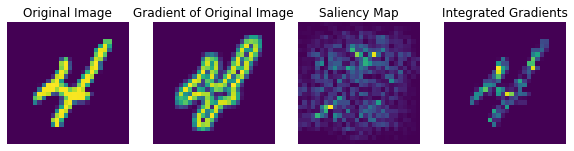

In [50]:
for i in range(10):
    original_image = train.train_data.cpu().numpy()[i]
    target_label = train.train_labels.cpu().numpy()[i]

    #Preprocessing the image
    input_image = torch.tensor(original_image).float().reshape(1, 1, 28, 28)
    baseline = torch.zeros(1, 1, 28, 28)
    predicted_label = torch.argmax(model(input_image)).item()
    #print('Target Label: ', target_label, 'Predicted Label:', predicted_label)

    # applying saliency map
    saliency = Saliency(model)
    attributions_saliency = saliency.attribute(input_image, target=predicted_label)
    
    # applying integrated gradients on the SoftmaxModel and input data point
    ig = IntegratedGradients(model)
    attributions_ig = ig.attribute(input_image, baselines = baseline, target=predicted_label)
    
    #Finding image gradient
    edges = filters.sobel(original_image)

    plt.figure(figsize=(10,5))
    plt.subplot(1, 4, 1)
    plt.imshow(original_image)
    plt.title('Original Image')
    plt.axis('off')
    
    plt.subplot(1, 4, 2)
    plt.imshow(edges)
    plt.title('Gradient of Original Image')
    plt.axis('off')
    
    plt.subplot(1, 4, 3)    
    plt.imshow(torch.abs(attributions_saliency.squeeze(0).squeeze(0)))
    #plt.colorbar()
    plt.title('Saliency Map')
    plt.axis('off')
    
    plt.subplot(1, 4, 4)    
    plt.imshow(torch.abs(attributions_ig.squeeze(0).squeeze(0)))
    #plt.colorbar()
    plt.title('Integrated Gradients')
    plt.axis('off')
    
    plt.show()